## 📦 Library Imports for NLP and Machine Learning

In this project, we aim to analyze and model text data from Yelp reviews using a range of natural language processing (NLP) and machine learning techniques. This cell imports all essential libraries needed for:

- **Data handling and visualization** (`pandas`, `numpy`, `matplotlib`, `seaborn`)
- **Text preprocessing and NLP** (`nltk`, `spacy`, `re`, `string`, `collections`)
- **Modeling and vectorization** (`scikit-learn`, `tensorflow`, `keras`)
- **Utility and performance monitoring** (`os`, `glob`, `psutil`, `gc`, `time`)
- **Interactive notebook enhancements** (`ipywidgets`, `google.colab`)

These tools form the foundation for data ingestion, exploratory analysis, feature engineering, and predictive modeling.

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import ast, re, string
from collections import Counter
from itertools import islice, tee

import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from scipy import sparse
from scipy.spatial.distance import cosine
from scipy.sparse import coo_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from google.colab import files
import os, glob, time, gc, psutil
import pathlib, datetime, platform, tempfile, logging
from pathlib import Path
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import Text, Button, Output, HBox

## 🔗 Mounting Google Drive and Linking Project Directory

To ensure smooth access to the dataset and other project files, this cell:

1. Mounts Google Drive within the Colab environment.
2. Creates a symbolic link to the `talkofthetown` project folder.

This setup enables persistent access to project resources across sessions and simplifies file path references.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/MyDrive/talkofthetown /content/talkofthetown

Mounted at /content/drive


## 📥 Installing spaCy Language Model

This command downloads the `en_core_web_lg` English model from spaCy, which includes pre-trained word vectors and linguistic annotations. The large model is particularly suited for in-depth NLP tasks such as named entity recognition, syntactic parsing, and semantic similarity—capabilities that will be leveraged throughout this project.

In [3]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 2.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 📂 Loading and Inspecting the Yelp Reviews Dataset

This step loads the preprocessed Yelp reviews CSV into a Pandas DataFrame and conducts an initial inspection. Specifically, we:

- Define the path to the dataset stored in Drive.
- Load the file while removing the unnecessary `name` column.
- Use `.info()` to understand the dataset’s structure and check for missing values.
- Preview the first five rows to get a sense of the available review data.

This step ensures the dataset is properly loaded and ready for cleaning, feature extraction, and modeling.

In [4]:
reviews_path = '/content/talkofthetown/data/yelp_academic_dataset_processed_reviews.csv'

reviews_df = pd.read_csv(reviews_path).drop(columns=['name'])
reviews_df.info()
reviews_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  250000 non-null  object 
 1   stars                 250000 non-null  float64
 2   date                  250000 non-null  object 
 3   business_id           250000 non-null  object 
 4   text_clean            249999 non-null  object 
 5   text_length           250000 non-null  int64  
 6   word_count            250000 non-null  int64  
 7   sentiment_binary      250000 non-null  int64  
 8   sentiment_multiclass  250000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 17.2+ MB


,text,stars,date,business_id,text_clean,text_length,word_count,sentiment_binary,sentiment_multiclass
0,I am a long term frequent customer of this est...,1.0,2015-09-23 23:10:31,04UD14gamNjLY0IDYVhHJg,i am a long term frequent customer of this est...,341,65,0,negative
1,"I got the gyro ""platter"" for lunch, which was ...",1.0,2012-09-10 17:07:50,-OIUunijjcq_ZzyyQhPPFQ,"i got the gyro ""platter"" for lunch, which was ...",279,48,0,negative
2,They served me a frozen pizza and skunked beer...,1.0,2008-04-30 14:54:01,VbItL6RDULtnw4YvB6EhVg,they served me a frozen pizza and skunked beer...,60,11,0,negative
3,I am positively LIVID.\n\nI went to check my a...,1.0,2009-10-15 00:08:18,R-HCwu9UbasUudG1yTM1Ow,i am positively livid. i went to check my acco...,998,193,0,negative
4,This place's posted hours include a 10PM closi...,1.0,2015-08-06 22:35:02,r2cjbHG_WGWUkaPCbLpo-A,this place's posted hours include a 10pm closi...,396,74,0,negative


## 🏙️ Loading and Previewing Business Metadata

In addition to the review text, this project incorporates **business-level metadata** to enrich our analysis. This cell performs the following:

- Loads the cleaned business dataset, limited to essential columns: `business_id`, `name`, and `city`.
- Ensures all fields are read as strings for consistency in merging and text operations.
- Displays dataset structure and a sample of rows to verify successful loading.

This information will later support merging business identifiers with their corresponding reviews, enabling **location-based insights** and more granular segmentation.

In [5]:
biz_path = '/content/talkofthetown/data/clean_data_business/business_clean.csv'

biz_df = pd.read_csv(biz_path, usecols=['business_id', 'name', 'city'], dtype=str)
biz_df.info()
biz_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   business_id  150346 non-null  object
 1   name         150346 non-null  object
 2   city         150346 non-null  object
dtypes: object(3)
memory usage: 3.4+ MB


,business_id,name,city
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ",Santa Barbara
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,Affton
2,tUFrWirKiKi_TAnsVWINQQ,Target,Tucson
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,Green Lane


## 🔗 Merging Reviews with Business Metadata

To enable more contextual and location-aware analysis, we merge the Yelp reviews dataset with the business metadata on the `business_id` field.

Key steps in this cell:
- **Merge**: Join review data with business information (`name`, `city`) using a left join.
- **Column Selection**: Keep only the most relevant columns for downstream tasks, including review content, metadata, sentiment labels, and text statistics.
- **Data Type Conversion**: Convert the `stars` rating to integer format for consistency in numeric operations.
- **Initial Inspection**: Use `.info()` and `.head()` to confirm the merge and validate the enriched dataset structure.

This integrated dataset forms the **core foundation** for sentiment analysis, city-level comparisons, and business-specific insights.

In [6]:
enriched_reviews_df = reviews_df.merge(biz_df, how='left', on='business_id')
cols = [
    'business_id',
    'name',
    'city',
    'date',
    'stars',
    'text',
    'text_clean',
    'text_length',
    'word_count',
    'sentiment_binary',
    'sentiment_multiclass'
]

enriched_reviews_df = enriched_reviews_df[cols]
enriched_reviews_df.stars = enriched_reviews_df.stars.astype(int)
enriched_reviews_df.info()
enriched_reviews_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   business_id           250000 non-null  object
 1   name                  250000 non-null  object
 2   city                  250000 non-null  object
 3   date                  250000 non-null  object
 4   stars                 250000 non-null  int64 
 5   text                  250000 non-null  object
 6   text_clean            249999 non-null  object
 7   text_length           250000 non-null  int64 
 8   word_count            250000 non-null  int64 
 9   sentiment_binary      250000 non-null  int64 
 10  sentiment_multiclass  250000 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.0+ MB


,business_id,name,city,date,stars,text,text_clean,text_length,word_count,sentiment_binary,sentiment_multiclass
0,04UD14gamNjLY0IDYVhHJg,Dmitri's,Philadelphia,2015-09-23 23:10:31,1,I am a long term frequent customer of this est...,i am a long term frequent customer of this est...,341,65,0,negative
1,-OIUunijjcq_ZzyyQhPPFQ,Zorba's Taverna,Philadelphia,2012-09-10 17:07:50,1,"I got the gyro ""platter"" for lunch, which was ...","i got the gyro ""platter"" for lunch, which was ...",279,48,0,negative
2,VbItL6RDULtnw4YvB6EhVg,Jon's Bar & Grille,Philadelphia,2008-04-30 14:54:01,1,They served me a frozen pizza and skunked beer...,they served me a frozen pizza and skunked beer...,60,11,0,negative
3,R-HCwu9UbasUudG1yTM1Ow,TD Banknorth,Philadelphia,2009-10-15 00:08:18,1,I am positively LIVID.\n\nI went to check my a...,i am positively livid. i went to check my acco...,998,193,0,negative
4,r2cjbHG_WGWUkaPCbLpo-A,Philly Fusion & Grill Chicken Bowl,Philadelphia,2015-08-06 22:35:02,1,This place's posted hours include a 10PM closi...,this place's posted hours include a 10pm closi...,396,74,0,negative


## 🌆 Analyzing Review Distribution by City

This cell examines the **geographic distribution** of Yelp reviews by counting how many reviews are associated with each city in the dataset. Specifically:

- Uses `value_counts()` to tally the number of reviews per city.
- Sorts the results in descending order to highlight the most frequently reviewed locations.

Understanding city-level distribution is crucial for:
- Identifying urban centers with the most data coverage.
- Selecting representative locations for focused analysis.
- Detecting potential data imbalances that could bias model performance.

These insights will help guide any location-specific deep dives or filtering in future steps.

In [7]:
city_counts = enriched_reviews_df['city'].value_counts(dropna=True).sort_values(ascending=False)
city_counts

,count
city,
Philadelphia,25000
New Orleans,25000
Tampa,25000
Nashville,25000
Tucson,25000
Indianapolis,25000
Reno,25000
Santa Barbara,25000
Saint Louis,25000


In [8]:
#enriched_reviews_df.to_csv('/content/talkofthetown/data/enriched_yelp_academic_dataset_processed_reviews.csv', index=False)

## 🧹 Text Preprocessing for Top Cities

To prepare the Yelp review text for downstream NLP tasks, this section applies a **custom preprocessing pipeline** to reviews from the top 11 most-reviewed cities.

Steps performed:

1. **Subset & Sort by City**: Select the top cities by review count and organize them by volume for easier processing.
2. **Download NLTK Resources**: Ensure necessary tokenizers and stopword lists are available.
3. **Load spaCy Model**: Initialize the `en_core_web_lg` model for potential later use in vectorization or entity recognition.
4. **Define Stopwords and Stemming**: Extend stopwords to include punctuation; use the Porter Stemmer for standardizing word forms.
5. **Preprocess Each Review**:
   - Convert to lowercase
   - Remove numbers, URLs, punctuation, and extra whitespace
   - Tokenize and stem words
   - Remove stopwords and short tokens
   - Store the resulting cleaned token list back into the original DataFrame

This standardized text representation will allow for consistent feature extraction, visualization, and model training across cities.


In [9]:
top_cities = city_counts.head(11).index.tolist()

city_dfs = {
    city: enriched_reviews_df[enriched_reviews_df['city'] == city] for city in top_cities
}

sorted_city_dfs = sorted(city_dfs.items(), key=lambda x: len(x[1]))

nltk.download('stopwords')
nltk.download('punkt_tab')

nlp = spacy.load('en_core_web_lg')

stop_words = set(stopwords.words('english'))
stop_words.update(string.punctuation)
stemmer = PorterStemmer()

for city, df in sorted_city_dfs:
    print(f"Processing {city}...")

    for i in range(len(df)):
        review = str(df.iloc[i, 5]).lower()  # column 5 = review text
        review = re.sub(r'\d+', '', review)  # Remove digits
        review = review.strip()
        review = re.sub(r"http\S+|www.\S+", '', review)  # Remove URLs
        review = review.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

        word_tokens = word_tokenize(review)
        filtered_words = [stemmer.stem(w) for w in word_tokens if w not in stop_words and len(w) > 1]

        df.iat[i, 5] = filtered_words  # Modify DataFrame directly, not a copy

    print(f"{city} processing completed!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Processing Philadelphia...
Philadelphia processing completed!
Processing New Orleans...
New Orleans processing completed!
Processing Tampa...
Tampa processing completed!
Processing Nashville...
Nashville processing completed!
Processing Tucson...
Tucson processing completed!
Processing Indianapolis...
Indianapolis processing completed!
Processing Reno...
Reno processing completed!
Processing Santa Barbara...
Santa Barbara processing completed!
Processing Saint Louis...
Saint Louis processing completed!
Processing Boise...
Boise processing completed!


## 💾 Saving Preprocessed City-Level Review Data

After preprocessing the reviews for the top 11 cities, this cell saves each city's DataFrame as a separate CSV file to a designated folder in Google Drive.

Steps performed:

- Iterates over the top cities and checks for valid data.
- Constructs a clean filename using the city name (spaces replaced with underscores).
- Saves each DataFrame to the `city_data/` subfolder within the project directory.
- Confirms successful saving with printed status messages.

Storing city-specific data separately supports:
- Modular analysis or model training per location.
- Efficient file management in long-term project development.
- Reusability for visualization, reporting, or external tools.

This step ensures **data persistence** and organization as the project progresses.


In [10]:
for city in top_cities:
  if city in city_dfs:
    # Construct the filename for the CSV
    filename = f'/content/drive/My Drive/talkofthetown/data/city_data/{city.replace(" ", "_")}_reviews.csv'
    print(f"Saving {city} data to {filename}")
    # Save the city's dataframe to a CSV file in Google Drive
    city_dfs[city].to_csv(filename, index=False)
    print(f"{city} data saved.")
  else:
    print(f"No data found for {city}.")

print("All specified city data saved.")

Saving Philadelphia data to /content/drive/My Drive/talkofthetown/data/city_data/Philadelphia_reviews.csv
Philadelphia data saved.
Saving New Orleans data to /content/drive/My Drive/talkofthetown/data/city_data/New_Orleans_reviews.csv
New Orleans data saved.
Saving Tampa data to /content/drive/My Drive/talkofthetown/data/city_data/Tampa_reviews.csv
Tampa data saved.
Saving Nashville data to /content/drive/My Drive/talkofthetown/data/city_data/Nashville_reviews.csv
Nashville data saved.
Saving Tucson data to /content/drive/My Drive/talkofthetown/data/city_data/Tucson_reviews.csv
Tucson data saved.
Saving Indianapolis data to /content/drive/My Drive/talkofthetown/data/city_data/Indianapolis_reviews.csv
Indianapolis data saved.
Saving Reno data to /content/drive/My Drive/talkofthetown/data/city_data/Reno_reviews.csv
Reno data saved.
Saving Santa Barbara data to /content/drive/My Drive/talkofthetown/data/city_data/Santa_Barbara_reviews.csv
Santa Barbara data saved.
Saving Saint Louis data 

## ☁️ Generating Word Clouds by Sentiment and City

This section visualizes the most frequent words used in reviews, grouped by **sentiment category** (`Bad`, `Mixed`, `Good`) across the top cities.

### What this code does:
- Defines custom sentiment groupings based on Yelp star ratings:
  - `Bad`: 1–2 stars
  - `Mixed`: 3 stars
  - `Good`: 4–5 stars
- Iterates through each city in the dataset and:
  - Extracts all tokens from reviews that fall into each sentiment group.
  - Concatenates the tokens into a single string.
  - Generates and displays a word cloud for each sentiment category using `WordCloud`.

### Purpose:
These visualizations help us:
- Identify **common themes and language patterns** in positive vs. negative reviews.
- Compare how sentiment is expressed differently **across cities**.
- Guide further feature engineering by surfacing domain-specific vocabulary.

This qualitative exploration enhances our understanding of the review data before moving into more advanced modeling.

In [11]:
# Categories for sentiment grouping
categories = {
    'Bad': [1, 2],
    'Mixed': [3],
    'Good': [4, 5]
}

# Loop over each city
for city, df in sorted_city_dfs:
    print(f"Processing: {city} (Reviews: {len(df)})")

    array = df.to_numpy()
    l = len(array)

    # Loop over each category (Bad, Mixed, Good)
    for category, ratings in categories.items():
        all_tokens = []

        for i in range(l):
            rating = array[i][4]
            tokens = array[i][5]  # Tokenized review content

            if rating in ratings and isinstance(tokens, list):
                all_tokens.extend(tokens)

        if not all_tokens:
            print(f"→ No tokens found for {category} reviews in {city}. Skipping wordcloud.")
            continue

        text = " ".join(all_tokens)
        wordcloud = WordCloud(width=800, height=600, background_color='white').generate(text)

        plt.figure(figsize=(10, 8))
        plt.title(f"{city} - {category} Reviews", fontsize=14)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 🧬 Rehydrating City-Level DataFrames from Saved Files

This step **automates the loading** of previously saved, city-specific CSV files back into the notebook environment as individual Pandas DataFrames.

### What the code does:
- Scans the `city_data/` directory for all files matching the `*_reviews.csv` pattern.
- Extracts the city name from each filename.
- Dynamically creates a named DataFrame (e.g., `Las_Vegas_reviews`) for each city using `globals()`.
- Tracks all created variable names for reference.

### Why this matters:
This modular loading approach:
- Ensures **scalability** by automatically adapting to available city data.
- Keeps each city's data isolated for **city-specific modeling or exploration**.
- Allows for **reproducibility** across sessions without manually rewriting import code.

This method is especially useful for running experiments or visualizations in parallel across multiple city datasets.

In [12]:
city_dir = '/content/talkofthetown/talkofthetown/data/city_data'
city_paths = glob.glob(os.path.join(city_dir, '*_reviews.csv'))

city_vars = []

for path in city_paths:

    city_name = os.path.basename(path).replace("_reviews.csv", "")
    var_name  = f"{city_name.replace(' ', '_')}_reviews"

    globals()[var_name] = pd.read_csv(path)   # Creating dataframe objects
    city_vars.append(var_name)

print("Created the following city dataframe objects:\n\n" + ",\n".join(city_vars))


Created the following city dataframe objects:

New_Orleans_reviews,
Philadelphia_reviews,
Tucson_reviews,
Tampa_reviews,
Nashville_reviews,
Indianapolis_reviews,
Reno_reviews,
Santa_Barbara_reviews,
Saint_Louis_reviews,
Boise_reviews


## 🧪 Keyword Extraction by City (Minimum Frequency Threshold)

This cell identifies **frequently used keywords** from the tokenized Yelp reviews in each city. The goal is to isolate meaningful vocabulary that appears often enough to be statistically relevant.

### Process:
- A global variable `MIN_TOKEN_FREQ` defines the minimum number of documents a token must appear in to be considered a keyword.
- For each city:
  - Converts the stored stringified token lists back into Python lists using `ast.literal_eval`.
  - Flattens all token lists and counts token frequency with `collections.Counter`.
  - Filters tokens based on the minimum frequency threshold.
  - Stores the resulting list of keywords in a new variable named `<city>_keywords`.

### Why this matters:
This step ensures that **low-signal or overly rare tokens** are removed from consideration in future modeling or analysis. It also prepares clean, filtered vocabularies for:
- **Vectorization** (e.g., Bag of Words, TF-IDF)
- **Topic modeling**
- **Feature selection**

By tailoring the keyword list to each city, we allow for **localized insights** and more accurate feature representation.

In [13]:
# MIN_TOKEN_FREQ: Only keeps tokens that appear in at least this* many documents
MIN_TOKEN_FREQ = 5 # Adjustable

for var in city_vars:
    base = var.replace("_reviews", "")
    print(f"Building {base}_keywords.")

    df = globals()[var]
    df.iloc[:, 5] = df.iloc[:, 5].apply(ast.literal_eval)
    token_lists = df.iloc[:, 5].tolist()

    tok_ctr = Counter(tok for doc in token_lists for tok in doc)

    keywords = sorted(tok for tok, cnt in tok_ctr.items() if cnt >= MIN_TOKEN_FREQ)

    globals()[f"{base}_keywords"] = keywords

    print(f"{len(keywords):,} unique tokens\n")

Building New_Orleans_keywords.
8,395 unique tokens

Building Philadelphia_keywords.
9,406 unique tokens

Building Tucson_keywords.
8,965 unique tokens

Building Tampa_keywords.
8,710 unique tokens

Building Nashville_keywords.
8,632 unique tokens

Building Indianapolis_keywords.
8,861 unique tokens

Building Reno_keywords.
8,866 unique tokens

Building Santa_Barbara_keywords.
8,857 unique tokens

Building Saint_Louis_keywords.
9,106 unique tokens

Building Boise_keywords.
8,800 unique tokens



## 🔄 Building Co-Occurrence Matrices by City

This section constructs **word co-occurrence matrices** for each selected city to analyze how often words appear near each other within a sliding window. These matrices form the basis for semantic similarity analysis, word embeddings, and other unsupervised NLP techniques.

### Breakdown of Components:

- **`sliding_windows()`**: A helper generator function that yields all word pairs within a given context window size `k` in each tokenized document.
  
- **`build_cooc()`**: The main function that:
  - Filters out tokens and pairs that don’t meet minimum frequency thresholds.
  - Maps each token to a matrix index (`vmap`).
  - Counts co-occurring word pairs using a context window (e.g., 10-word span).
  - Builds a **sparse co-occurrence matrix** using Scipy for memory efficiency.
  - Converts the matrix to a **pandas DataFrame (`glove_df`)** for inspection or export.

### Processing Loop:
The bottom part loops through 10 selected cities, and for each:
- Retrieves tokenized reviews and filtered keyword vocabulary.
- Builds the sparse matrix and labeled DataFrame using `build_cooc()`.
- Stores both artifacts as global variables:  
  - `<city>_matrix`: Sparse co-occurrence matrix (for modeling)
  - `<city>_glove`: DataFrame version (for interpretation/visualization)

### Purpose:
These matrices will later be used for:
- **Constructing word embeddings** (e.g., via GloVe-style matrix factorization)
- **Exploring word associations and semantic networks** within each city
- **Comparing language use across geographic contexts**

This stage enables the transition from raw tokens to structured semantic representations.

In [14]:
def sliding_windows(tokens, k=2):
    for i, w in enumerate(tokens):
        for j in range(1, k+1):
            if i + j < len(tokens):
                yield w, tokens[i+j]

def build_cooc(token_lists, vocab,
                            window,
                            min_tok_freq,
                            min_pair_freq):

    # Token–frequency filter
    tok_ctr = Counter(t for doc in token_lists for t in doc)
    vocab   = [t for t in vocab if tok_ctr[t] >= min_tok_freq]
    if not vocab:
        n    = 0
        zero = sparse.csr_matrix((0, 0), dtype=int)
        return zero, pd.DataFrame.sparse.from_spmatrix(zero,
                                                       index=vocab,
                                                       columns=vocab)

    # Map tokens → row/col indices
    vmap = {w: i for i, w in enumerate(vocab)}

    # Build sliding-window pair counts
    pair_ctr = Counter()
    for tokens in token_lists:
        for w1, w2 in sliding_windows(tokens, window):
            if w1 in vmap and w2 in vmap:
                pair_ctr[(vmap[w1], vmap[w2])] += 1

    # Pair–frequency filter
    pair_ctr = {pair: c for pair, c in pair_ctr.items()
                      if c >= min_pair_freq}

    # Condition if no pairs survived
    if not pair_ctr:
        n    = len(vocab)
        zero = sparse.csr_matrix((n, n), dtype=int)
        return None, print('No pairs survived.')

    # Build sparse coo → csr
    rows, cols, data = zip(*((i, j, c) for (i, j), c in pair_ctr.items()))
    coo = sparse.coo_matrix((data, (rows, cols)),
                             shape=(len(vocab), len(vocab)),
                             dtype=int).tocsr()

    glove_df = pd.DataFrame.sparse.from_spmatrix(coo,
                                                 index=vocab,
                                                 columns=vocab)
    return coo, glove_df

cities = [
    "Indianapolis","Boise","Philadelphia",
    "New_Orleans","Nashville","Tampa",
    "Santa_Barbara","Saint_Louis","Reno","Tucson"
]

for city in cities:
    print(f"\nBuilding {city} co-occurrence…")
    df     = globals()[f"{city}_reviews"]
    tokens = df.iloc[:, 5].tolist()
    vocab  = globals()[f"{city}_keywords"]

    mat, glove = build_cooc(
        token_lists = tokens,
        vocab       = vocab,
        window      = 10,
        min_tok_freq= 5,
        min_pair_freq=3
    )

    globals()[f"{city}_matrix"] = mat
    globals()[f"{city}_glove"]  = glove

    print(f"Shapes:  _matrix {mat.shape}, _glove {glove.shape}\n")


Building Indianapolis co-occurrence…
Shapes:  _matrix (8861, 8861), _glove (8861, 8861)


Building Boise co-occurrence…
Shapes:  _matrix (8800, 8800), _glove (8800, 8800)


Building Philadelphia co-occurrence…
Shapes:  _matrix (9406, 9406), _glove (9406, 9406)


Building New_Orleans co-occurrence…
Shapes:  _matrix (8395, 8395), _glove (8395, 8395)


Building Nashville co-occurrence…
Shapes:  _matrix (8632, 8632), _glove (8632, 8632)


Building Tampa co-occurrence…
Shapes:  _matrix (8710, 8710), _glove (8710, 8710)


Building Santa_Barbara co-occurrence…
Shapes:  _matrix (8857, 8857), _glove (8857, 8857)


Building Saint_Louis co-occurrence…
Shapes:  _matrix (9106, 9106), _glove (9106, 9106)


Building Reno co-occurrence…
Shapes:  _matrix (8866, 8866), _glove (8866, 8866)


Building Tucson co-occurrence…
Shapes:  _matrix (8965, 8965), _glove (8965, 8965)



## ✅ Validating Co-Occurrence Matrix Output

After generating co-occurrence matrices for each city, it's essential to **verify that the matrix was constructed correctly**. This cell inspects the sparse matrix for `Indianapolis` to confirm:

- The matrix has the expected shape.
- Word co-occurrence counts are present.
- The structure aligns with the previously filtered keyword vocabulary.

This validation step ensures the matrix is ready for downstream tasks like dimensionality reduction, embedding construction, or similarity analysis.

In [15]:
# Matrix Validation
Indianapolis_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 871157 stored elements and shape (8861, 8861)>

## 📊 Validating GloVe-style Co-Occurrence DataFrame

This cell displays the **GloVe-style co-occurrence DataFrame** for `Indianapolis`. This matrix provides a labeled view of how often each pair of frequently used words appears within a fixed context window across the city’s reviews.

### Why this matters:
- Columns and rows are labeled with the filtered keywords (`Indianapolis_keywords`).
- Each cell represents the **raw co-occurrence count** between two terms.
- It serves as a more interpretable version of the underlying sparse matrix.

This validation confirms that the token filtering, co-occurrence logic, and DataFrame construction were all executed correctly—setting the stage for further semantic analysis, dimensionality reduction, or clustering based on word usage patterns.

In [16]:
# GloVe df Validation
Indianapolis_glove

,aaa,ab,aback,abandon,abil,abl,abomin,abound,aboveaverag,abras,...,zing,zinger,zionsvil,zip,ziti,zombi,zone,zoo,zucchini,étouffé
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aback,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zone,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zoo,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zucchini,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0


## 📈 Co-Occurrence Matrix Summary Statistics by City

This step generates a **quantitative summary** of the co-occurrence matrices built for each city, providing insight into their structure and sparsity.

### Key Metrics:
- **`vocab_size`**: Number of unique tokens (rows/columns) in the matrix.
- **`nonzero_count`**: Number of word pairs with nonzero co-occurrence.
- **`total_count`**: Sum of all co-occurrence values (i.e., total observed word-pair interactions).
- **`pct_nonzero`**: The percentage of nonzero entries relative to the total co-occurrence sum—used to assess matrix density.

### Purpose:
- **Validate**: Confirms that co-occurrence data was populated correctly.
- **Compare**: Highlights differences in vocabulary richness and token connectivity across cities.
- **Interpret**: Helps gauge which matrices may be more useful for tasks like dimensionality reduction, semantic embedding, or network analysis.

This summary gives a high-level view of the **semantic complexity** and **textual density** present in each city's review corpus.

In [17]:
matrices = {
    name.replace("_matrix", ""): obj
    for name, obj in globals().items()
    if name.endswith("_matrix") and hasattr(obj, 'data')}


records = []
for city, mat in matrices.items():
    nnz      = mat.nnz                    # number of nonzero entries
    total    = mat.data.sum()             # sum of all co-occurrence counts
    pct_nz   = 100 * (nnz / total)        # percent nonzero

    records.append({
        "city":        city,
        "vocab_size":  mat.shape[0],
        "nonzero_count": nnz,
        "total_count": total,
        "pct_nonzero": pct_nz
    })

summary = pd.DataFrame.from_records(records).set_index("city")
display(summary.style.format({
    "vocab_size":"{:,}",
    "nonzero_count":"{:,}",
    "total_count":"{:,}",
    "pct_nonzero":"{:.2f}%"
}))

,vocab_size,nonzero_count,total_count,pct_nonzero
city,,,,
Indianapolis,"8,861","871,157","9,597,519",9.08%
Boise,"8,800","838,831","9,129,393",9.19%
Philadelphia,"9,406","900,944","9,946,065",9.06%
New_Orleans,"8,395","815,996","9,182,692",8.89%
Nashville,"8,632","860,291","9,709,422",8.86%
Tampa,"8,710","858,486","9,378,870",9.15%
Santa_Barbara,"8,857","844,576","9,119,670",9.26%
Saint_Louis,"9,106","913,797","10,347,694",8.83%
Reno,"8,866","901,764","10,116,007",8.91%


## 🔍 Top Word Pair Co-Occurrences by City

This step extracts and displays the **top 20 most frequent word co-occurrences** from the previously built matrices for each city.

### Process:
- Converts each city’s sparse co-occurrence matrix to COO format for easy access to row, column, and value triplets.
- Uses city-specific vocabularies to map index positions back to actual words.
- Sorts word pairs by descending frequency and stores the top 20 pairs in a report.
- Combines all city reports into a **multi-indexed wide DataFrame** for side-by-side comparison.

### Purpose:
- Highlights the **most contextually connected word pairs** in each city’s review corpus.
- Provides a qualitative snapshot of **local semantic patterns** (e.g., frequent phrases or sentiment-linked terms).
- Serves as an interpretable bridge between raw token data and more complex modeling techniques like embeddings or topic modeling.

This analysis supports city-specific storytelling and offers a lens into **how language and sentiment vary geographically** in Yelp reviews.

In [18]:
n = 20
reports = {}

for var in city_vars:
    base = var.replace("_reviews","")
    mat  = globals()[f"{base}_matrix"].tocoo()
    vocab = globals()[f"{base}_keywords"]

    triples = sorted(
        zip(mat.row, mat.col, mat.data),
        key=lambda x: -x[2])[:n]

    df = pd.DataFrame(
        [(vocab[r], vocab[c], cnt) for r,c,cnt in triples],
        columns=["1","2","count"])
    reports[base] = df

# ________________________________________________________________

wide = pd.concat(
    reports.values(),
    axis=1,
    keys=reports.keys())
wide.columns.names = ["city","token"]

display(wide)

#__________________________________________________________________

# For by-city reporting, use the below content in place of the above^ (between the lines):
# for city, df in reports.items():
#     print(f"\nTop {n} Co‐occurrences in {city}\n" + "-"*40)
#     display(df)

city  New_Orleans               Philadelphia                Tucson          \
token           1       2 count            1       2 count       1       2   
0             new  orlean  4435         food    good  2534    food    good   
1            food    good  2527        order   order  2264      go    back   
2           order   order  2013           go    back  2183   order   order   
3            food  servic  2006         food    food  2101    food    food   
4            food    food  2004        place    food  1947    good    good   
5            good    good  1934         good    good  1848    good    food   
6              go    back  1813         good    food  1702    food  servic   
7            good    food  1811         food  servic  1653  custom  servic   
8          servic    food  1742         food   order  1584   place    food   
9           place    food  1732         come    back  1546  servic    food   
10         shrimp    grit  1683        place   place  1466    come    back   
11          great    food  1558       realli    good  1422    time    time   
12           food   order  1534        order    food  1417   place   place   
13          order    food  1491        great    food  1395    good  servic   
14             us      us  1480         food   place  1393   first    time   
15           food   great  1390         good   place  1392   place    good   
16           good  servic  1389        place    good  1392   place      go   
17         realli    good  1383       servic    food  1359    food   order   
18          place    good  1313        first    time  1354   great    food   
19           good   place  1312         time    time  1335    good   place   

city          Tampa  ...  Reno Santa_Barbara                Saint_Louis  \
token count       1  ... count             1        2 count           1   
0      2480    food  ...  2630         santa  barbara  4701          st   
1      2109    food  ...  2358          food     good  2135       order   
2      2076   order  ...  2224         order    order  1774        food   
3      1975      go  ...  2089            go     back  1672          go   
4      1919    good  ...  1937          good     good  1642        good   
5      1909    good  ...  1934          food   servic  1634         ice   
6      1780    food  ...  1890          food     food  1599        food   
7      1671   place  ...  1842         place     food  1566        food   
8      1597  custom  ...  1800          come     back  1559        good   
9      1483   great  ...  1676          good     food  1479       place   
10     1418    food  ...  1594         place    place  1478      servic   
11     1418    come  ...  1505        custom   servic  1349        food   
12     1409  servic  ...  1477         place     good  1348       order   
13     1395   first  ...  1467        servic     food  1330        come   
14     1370    good  ...  1440            us       us  1317       place   
15     1348    time  ...  1436          good    place  1308        time   
16     1304    food  ...  1417          good   servic  1277      burger   
17     1300   order  ...  1380          clam  chowder  1276      realli   
18     1299   place  ...  1361         great     food  1262      pretti   
19     1278   place  ...  1356         great    place  1245       place   

city                  Boise                
token       2 count       1       2 count  
0        loui  3555    food    good  2532  
1       order  2499      go    back  2098  
2        good  2467   order   order  2050  
3        back  2427    food    food  2026  
4        good  2074    good    good  2012  
5       cream  2059    food  servic  1975  
6        food  1892    good    food  1968  
7      servic  1683   place    food  1653  
8        food  1660  custom  servic  1634  
9        food  1648   great    food  1592  
10       food  1513  servic    food  1579  
11      order  1481    time    time  1513  
12       food  1

## 📏 Interactive Semantic Distance Explorer (Cosine Distance)

This cell provides an interactive tool to **compare the semantic similarity of two words** across different cities based on their GloVe-style co-occurrence embeddings.

### How It Works:
- Uses each city’s GloVe-style co-occurrence DataFrame to extract vector representations of the two input words.
- Computes the **cosine distance** between the vectors, where:
  - Smaller values → more similar word usage in context
  - Larger values → less similarity in context
- Displays the results in a sorted table to show **how similarly or differently the words co-occur** across cities.

### Interactive Components:
- `Word 1` and `Word 2` text fields let users input any two keywords.
- `Compute Distances` button triggers calculation and displays results.
- Missing vectors (e.g., if a word is not in a city's vocabulary) are handled gracefully with `NaN`.

### Why This Matters:
This tool enables:
- **Qualitative comparison** of how word associations shift across geographic regions.
- Detection of **local linguistic patterns** or sentiment framing (e.g., does "service" appear closer to "friendly" in one city but not another?).
- A **user-friendly entry point** to semantic analysis, helpful for both exploration and presentation.

This feature turns static embeddings into an **interactive and interpretable analysis asset**.

In [19]:
def cosine_distances_df(glove_map, w1, w2):

    col = f"{w1}_{w2}_cosine_dist"
    records = []
    for city, df in glove_map.items():
        if {w1, w2}.issubset(df.index):
            v1 = df.loc[w1].to_numpy()
            v2 = df.loc[w2].to_numpy()
            dist = cosine(v1, v2)
        else:
            dist = float("nan")
        records.append((city, dist))
    result = pd.DataFrame(records, columns=["city", col])
    return result.sort_values(col).reset_index(drop=True)

cities = [
    "Indianapolis","Boise","Philadelphia",
    "New_Orleans","Nashville","Tampa",
    "Santa_Barbara","Saint_Louis","Reno","Tucson"
]

glove_map = {city: globals()[f"{city}_glove"] for city in cities}

def display_cosine_distance_widget(glove_map):

    w1_dist = Text(value="menu", description="Word 1:")
    w2_dist = Text(value="great", description="Word 2:")
    btn_dist = Button(description="Compute Distances", button_style="info")
    out_dist = Output()

    def on_dist_click(_):
        with out_dist:
            out_dist.clear_output()
            df = cosine_distances_df(glove_map, w1_dist.value.strip(), w2_dist.value.strip())
            display(df)

    btn_dist.on_click(on_dist_click)
    display(HBox([w1_dist, w2_dist, btn_dist]), out_dist)



In [20]:
display_cosine_distance_widget(glove_map)

Output()

## 🔍 Compare Word Similarity Across Cities (Cosine Similarity Tool)

This interactive widget allows users to measure how **semantically similar two words** are within Yelp reviews from different cities, using the **cosine similarity** of their GloVe-style co-occurrence vectors.

### Key Features:
- **Cosine Similarity** is computed as:  
  \[ \text{Similarity} = 1 - \text{cosine distance} \]  
  Values closer to **1** indicate stronger semantic similarity.
- Looks up the vector representations of two user-specified words from each city’s GloVe-style co-occurrence DataFrame.
- Returns a ranked list of cities based on how strongly the two words co-occur in similar contexts.
- Automatically handles missing words by returning `NaN` if a word does not appear in a city's vocabulary.

### Interactive Interface:
- Text inputs allow flexible word comparison (e.g., `"menu"` vs `"service"`).
- Green “Compute Similarities” button runs the comparison.
- Results are displayed in a clean, sortable DataFrame below the input.

### Why This Is Valuable:
- Helps uncover **regional nuances in language use** (e.g., does "cheap" align with "good" in some cities but not others?).
- Supports **hypothesis generation** around brand perception, customer expectations, and service framing.
- Demonstrates how **distributional semantics** can reveal real-world insights from unstructured text.

This tool encourages exploration and **bridges computational outputs with human interpretation**.

In [21]:
def cosine_sims_df(glove_map, w1, w2):

    col = f"{w1}_{w2}_cosine_sim"
    records = []
    for city, df in glove_map.items():
        if {w1, w2}.issubset(df.index):
            v1  = df.loc[w1].to_numpy()
            v2  = df.loc[w2].to_numpy()
            sim = 1.0 - cosine(v1, v2)
        else:
            sim = float("nan")
        records.append((city, sim))
    result = pd.DataFrame(records, columns=["city", col])
    return result.sort_values(col).reset_index(drop=True)

cities = [
    "Indianapolis","Boise","Philadelphia",
    "New_Orleans","Nashville","Tampa",
    "Santa_Barbara","Saint_Louis","Reno","Tucson"
]

glove_map = {city: globals()[f"{city}_glove"] for city in cities}

def display_cosine_similarity_widget(glove_map):

    w1_sim = Text(value="menu", description="Word 1:")
    w2_sim = Text(value="great", description="Word 2:")
    btn_sim = Button(description="Compute Similarities", button_style="success")
    out_sim = Output()

    def on_sim_click(_):
        with out_sim:
            out_sim.clear_output()
            df = cosine_sims_df(glove_map, w1_sim.value.strip(), w2_sim.value.strip())
            display(df)

    btn_sim.on_click(on_sim_click)
    display(HBox([w1_sim, w2_sim, btn_sim]), out_sim)



In [22]:
display_cosine_similarity_widget(glove_map)

Output()

In [23]:
# hyperparameters
EMBED_DIM = 100
X_MAX     = 100
ALPHA     = 0.75
LR        = 0.05
EPOCHS    = 50
BATCH     = 1_000_000   # number of nonzero pairs to process per step
SEED      = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

#building training data from sparse _matrix matrices
def make_glove_training_data(csr: coo_matrix):
    # extract only the non-zero co-occurrences
    coo = csr.tocoo()
    rows  = coo.row.astype(np.int32)
    cols  = coo.col.astype(np.int32)
    counts= coo.data.astype(np.float32)
    # f(X) weighting function computation
    weights = np.where(counts < X_MAX,
                       (counts / X_MAX) ** ALPHA,
                       np.ones_like(counts, dtype=np.float32))
    return rows, cols, counts, weights

# TensorFlow GloVe training loop
def train_glove_tf(csr: coo_matrix):
    V = csr.shape[0]
    rows, cols, counts, weights = make_glove_training_data(csr)

    W  = tf.Variable(tf.random.uniform([V, EMBED_DIM], -0.5/EMBED_DIM, 0.5/EMBED_DIM)) # word vectors
    C  = tf.Variable(tf.random.uniform([V, EMBED_DIM], -0.5/EMBED_DIM, 0.5/EMBED_DIM)) # context vectors
    bW = tf.Variable(tf.zeros([V], dtype=tf.float32))                                  # bias for 'word vectors'
    bC = tf.Variable(tf.zeros([V], dtype=tf.float32))                                  # bias for 'context vectors'

    optimizer = tf.keras.optimizers.Adagrad(learning_rate=LR)

    dataset = tf.data.Dataset.from_tensor_slices((rows, cols, counts, weights))
    dataset = dataset.shuffle(len(counts), seed=SEED).batch(BATCH)

    for epoch in range(1, EPOCHS+1):
        epoch_loss = 0.0
        for batch_rows, batch_cols, batch_counts, batch_w in dataset:
            with tf.GradientTape() as tape:
                # look up vectors & biases
                w_i = tf.gather(W,  batch_rows)
                c_j = tf.gather(C,  batch_cols)
                bi  = tf.gather(bW, batch_rows)
                bj  = tf.gather(bC, batch_cols)

                # GloVe model: w_i · c_j + b_i + b_j ≈ log(X_ij)
                pred = tf.reduce_sum(w_i * c_j, axis=1) + bi + bj
                loss = batch_w * tf.square(pred - tf.math.log(batch_counts))
                loss = tf.reduce_sum(loss)

            grads = tape.gradient(loss, [W, C, bW, bC])
            optimizer.apply_gradients(zip(grads, [W, C, bW, bC]))
            epoch_loss += loss.numpy()

        print(f"Epoch {epoch:2d}/{EPOCHS} — loss: {epoch_loss:,.1f}")

    return W.numpy() + C.numpy()

cities = [
    "Indianapolis","Boise","Philadelphia",
    "New_Orleans","Nashville","Tampa",
    "Santa_Barbara","Saint_Louis","Reno","Tucson"
]

for city in cities:
    print(f"\nTraining GloVe for {city} (V={globals()[f'{city}_matrix'].shape[0]})")
    csr   = globals()[f"{city}_matrix"]       # sparse co-occurrence
    emb   = train_glove_tf(csr)               # embedding numpy array
    vocab = globals()[f"{city}_keywords"]     # object vocabulary storage

    # storing results as DataFrames for subsequent steps
    globals()[f"{city}_glove_trained"] = (
        pd.DataFrame(emb, index=vocab)
    )
    print(f"{city}_glove_trained shape: {emb.shape}")



Training GloVe for Indianapolis (V=8861)
Epoch  1/50 — loss: 1,139,961.1
Epoch  2/50 — loss: 218,925.6
Epoch  3/50 — loss: 67,975.6
Epoch  4/50 — loss: 46,577,304.0
Epoch  5/50 — loss: 3,022,365.8
Epoch  6/50 — loss: 6,824,410.5
Epoch  7/50 — loss: 1,568,780.8
Epoch  8/50 — loss: 230,555.9
Epoch  9/50 — loss: 106,351.2
Epoch 10/50 — loss: 66,955.2
Epoch 11/50 — loss: 51,794.4
Epoch 12/50 — loss: 44,606.2
Epoch 13/50 — loss: 40,481.9
Epoch 14/50 — loss: 37,833.3
Epoch 15/50 — loss: 36,014.6
Epoch 16/50 — loss: 34,707.8
Epoch 17/50 — loss: 33,729.0
Epoch 18/50 — loss: 32,968.7
Epoch 19/50 — loss: 32,357.7
Epoch 20/50 — loss: 31,852.1
Epoch 21/50 — loss: 31,422.7
Epoch 22/50 — loss: 31,050.0
Epoch 23/50 — loss: 30,720.3
Epoch 24/50 — loss: 30,424.2
Epoch 25/50 — loss: 30,154.8
Epoch 26/50 — loss: 29,906.9
Epoch 27/50 — loss: 29,676.8
Epoch 28/50 — loss: 29,461.6
Epoch 29/50 — loss: 29,259.0
Epoch 30/50 — loss: 29,067.3
Epoch 31/50 — loss: 28,885.0
Epoch 32/50 — loss: 28,711.0
Epoch 33/50

In [119]:
root = pathlib.Path("/content/talkofthetown/data/glove_embeddings")
root.mkdir(parents=True, exist_ok=True)

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s",
                    handlers=[
                        logging.StreamHandler(),
                        logging.FileHandler(root / "embeddings.log", mode="a")
                        ],force=True
                    )

logger = logging.getLogger("embeddings")
logger.info('Logger test')

def atomic_npz(path: pathlib.Path, **arrays):

    fd, tmp_name = tempfile.mkstemp(suffix=".npz", dir=str(path.parent))
    os.close(fd)

    try:
        np.savez_compressed(tmp_name, **arrays)
        size = Path(tmp_name).stat().st_size
        Path(tmp_name).replace(path)

        return size

    except Exception:
        try:
            os.remove(tmp_name)
        except OSError:
            pass
        raise

embedding_map = {
    city: globals()[f'{city}_glove_trained']
    for city in cities}

embedding_dict = {}

for city, df in embedding_map.items():
                embedding_dict[f"{city}_embeds"] = df.to_numpy(dtype=np.float32)
                embedding_dict[f"{city}_vocab"]  = np.array(df.index, dtype="U")

master_path                                      = root / "master_embeddings.npz"
master_file_size                                 = atomic_npz(master_path, **embedding_dict)

logger.info(f'Archived master embeddings. File size: ({master_file_size/1e6:.1f} MB - File name: {master_path.name}')

print("All-city master file written and verified.")

now = datetime.datetime.utcnow().isoformat(timespec='seconds') + 'Z'

for city, df in embedding_map.items():
                city_embeddings         = df.to_numpy(dtype=np.float32)
                vocab                   = np.array(df.index, dtype="U")
                metadata                = np.array([
                                        f'created={city}',
                                        f'dim={df.shape[1]}',
                                        f'python_version={platform.python_version()}',
                                        ], dtype="U")
                city_path               = root / f'{city}.npz'
                city_file_size          = atomic_npz(city_path,
                embeds                  = city_embeddings,
                vocab                   = vocab,
                metadata                = metadata)
                logger.info(f'Archived {city} embeddings. File size: ({city_file_size/1e6:.1f} MB - File name: {city_path.name}')

                loaded = np.load(city_path, mmap_mode="r")
                assert loaded['embeds'].shape == city_embeddings.shape, f"Shape mismatch in {city}"

                logger.info(f"{city} is looking good.")

print("All per-city files written and verified.")

2025-07-06 06:46:55,642 [INFO] Logger test
2025-07-06 06:46:58,155 [INFO] Archived master embeddings. File size: (33.8 MB - File name: master_embeddings.npz


All-city master file written and verified.


2025-07-06 06:46:58,364 [INFO] Archived Indianapolis embeddings. File size: (3.4 MB - File name: Indianapolis.npz
2025-07-06 06:46:58,392 [INFO] Indianapolis is looking good.
2025-07-06 06:46:58,668 [INFO] Archived Boise embeddings. File size: (3.4 MB - File name: Boise.npz
2025-07-06 06:46:58,697 [INFO] Boise is looking good.
2025-07-06 06:46:58,919 [INFO] Archived Philadelphia embeddings. File size: (3.6 MB - File name: Philadelphia.npz
2025-07-06 06:46:58,950 [INFO] Philadelphia is looking good.
2025-07-06 06:46:59,152 [INFO] Archived New_Orleans embeddings. File size: (3.2 MB - File name: New_Orleans.npz
2025-07-06 06:46:59,499 [INFO] New_Orleans is looking good.
2025-07-06 06:47:00,142 [INFO] Archived Nashville embeddings. File size: (3.3 MB - File name: Nashville.npz
2025-07-06 06:47:00,281 [INFO] Nashville is looking good.
2025-07-06 06:47:00,490 [INFO] Archived Tampa embeddings. File size: (3.3 MB - File name: Tampa.npz
2025-07-06 06:47:00,518 [INFO] Tampa is looking good.
2025

All per-city files written and verified.


In [103]:
data = np.load("/content/talkofthetown/data/glove_embeddings/Boise.npz", mmap_mode="r")
print(data.files, data["embeds"].shape)

['embeds', 'vocab', 'metadata'] (8800, 100)


In [104]:
display_cosine_distance_widget(embedding_map)

Output()

In [105]:
display_cosine_similarity_widget(embedding_map)

Output()

**Per-City Binary Sentiment Classification (Logistic Regression)**

In [113]:
reviews_map = {city: globals()[f'{city}_reviews']  for city in cities}

for city in cities:

    data   = np.load(root / f"{city}.npz", mmap_mode="r")
    matrix = data["embeds"]            # shape = (V, D)
    vocab  = data["vocab"].tolist()    # list of V tokens
    token2idx = {tok:i for i,tok in enumerate(vocab)}

    df      = reviews_map[city]
    token_lists = df["text"]           # list-of-token lists
    stars       = df["stars"].values

    D = matrix.shape[1]
    X, y = [], []

    for toks, star in zip(token_lists, stars):
        vecs = [matrix[token2idx[t]] for t in toks if t in token2idx]
        doc = np.mean(vecs, axis=0) if vecs else np.zeros(D)
        X.append(doc)
        y.append(1 if star >= 4 else 0)

    X = np.vstack(X).astype("float32")
    y = np.array(y, dtype="int8")

    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=0
    )
    clf = LogisticRegression(max_iter=1000, n_jobs=-1).fit(Xtr, ytr)

    yhat = clf.predict(Xte)
    print(f"\n=== {city} Report ===")
    print(classification_report(yte, yhat,
                            target_names=['negative', 'positive']))



=== Indianapolis Report ===
              precision    recall  f1-score   support

    negative       0.81      0.88      0.84      3000
    positive       0.79      0.68      0.73      2000

    accuracy                           0.80      5000
   macro avg       0.80      0.78      0.79      5000
weighted avg       0.80      0.80      0.80      5000


=== Boise Report ===
              precision    recall  f1-score   support

    negative       0.80      0.89      0.84      3000
    positive       0.79      0.66      0.72      2000

    accuracy                           0.80      5000
   macro avg       0.79      0.77      0.78      5000
weighted avg       0.79      0.80      0.79      5000


=== Philadelphia Report ===
              precision    recall  f1-score   support

    negative       0.75      0.85      0.80      3000
    positive       0.72      0.56      0.63      2000

    accuracy                           0.74      5000
   macro avg       0.73      0.71      0.72     

**Cumulative Per-City Confusion Matrix**

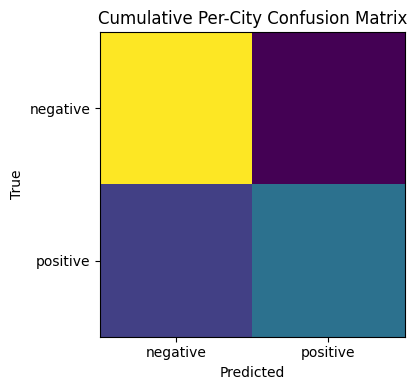

In [118]:
cm = confusion_matrix(yte, yhat, labels=[0,1])

plt.figure(figsize=(6,4))
plt.imshow(cm, interpolation='nearest')
plt.xticks([0,1], ['negative', 'positive'])
plt.yticks([0,1], ['negative', 'positive'])
plt.title('Cumulative Per-City Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

**Individual Per-City Confusion Matrices**

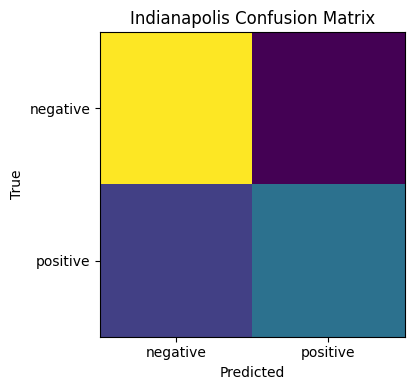

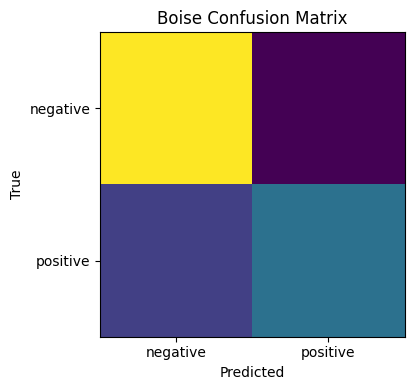

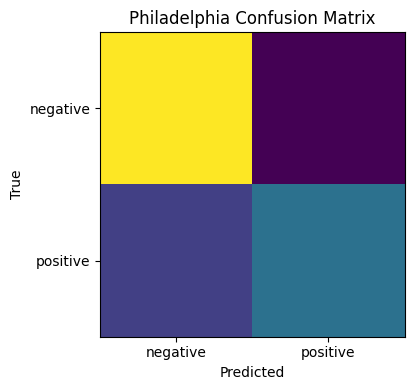

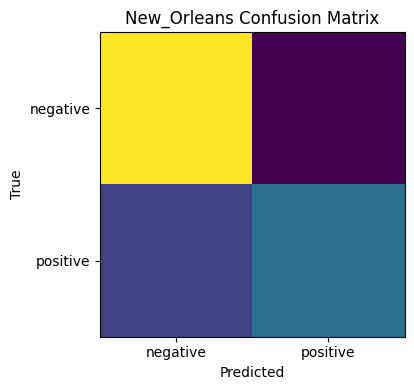

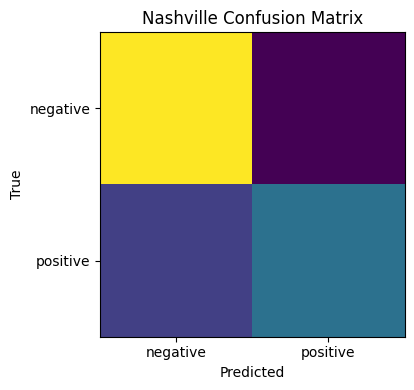

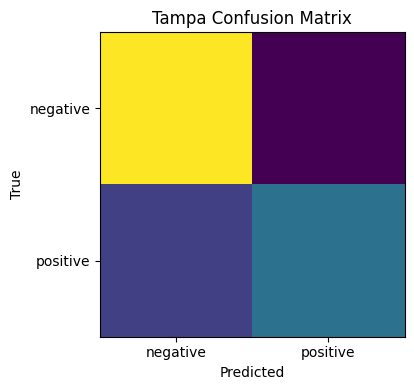

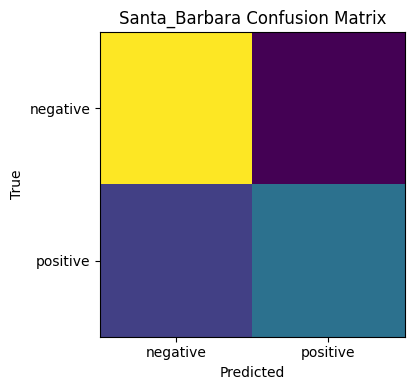

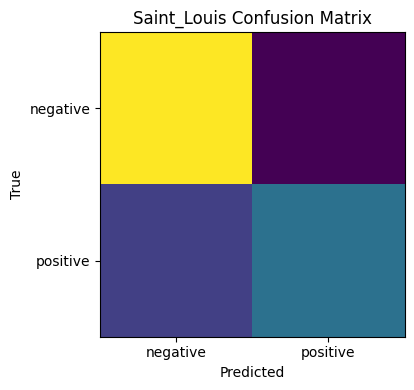

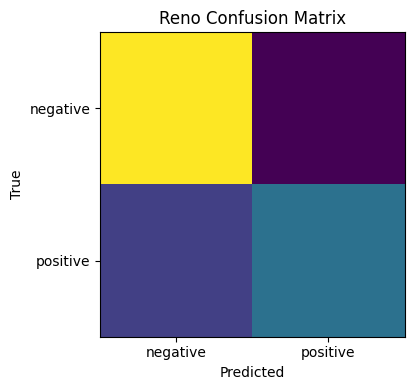

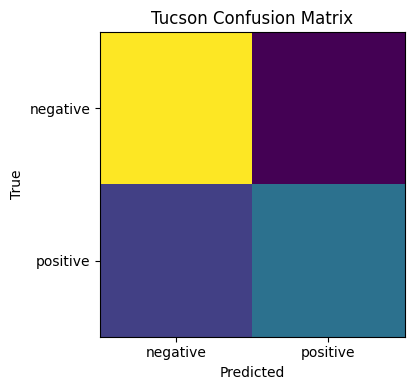

In [115]:
for city in cities:
    cm = confusion_matrix(yte, yhat, labels=[0,1])
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation="nearest")
    plt.xticks([0,1], ["negative","positive"])
    plt.yticks([0,1], ["negative","positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{city} Confusion Matrix")
    plt.tight_layout()
    plt.show()